# Import data

*Required dependencies*

- pandas
- pyarrow / fastparquet
- folium
- branca (with folium)


In [ ]:
# mount drive to access files
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
! unzip "/content/drive/MyDrive/Grab-Posisi dataset/grab-posis-city=Singapore.zip"

Archive:  /content/drive/MyDrive/Grab-Posisi dataset/grab-posis-city=Singapore.zip
   creating: city=Singapore/
  inflating: city=Singapore/part-00003-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Singapore/part-00008-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Singapore/part-00004-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Singapore/part-00005-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Singapore/part-00002-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Singapore/part-00009-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Singapore/part-00007-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Singapore/part-00000-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Singapore/part-00001-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  infl

# Data preparation and engineering

In [ ]:
import pandas as pd
import datetime

In [ ]:
df = pd.read_parquet("/content/city=Singapore/part-00000-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet", engine = 'pyarrow')
df

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy
0,70014,car,android,1554943236,1.342326,103.888969,18.910000,248,3.9
1,73573,car,android,1555582623,1.321781,103.856366,17.719076,44,4.0
2,75567,car,android,1555141026,1.327088,103.861273,14.021548,34,3.9
3,1410,car,android,1555731693,1.262482,103.823794,13.026521,181,4.0
4,4354,car,android,1555584497,1.283799,103.807210,14.812943,93,3.9
...,...,...,...,...,...,...,...,...,...
3034548,67126,car,android,1554971237,1.349722,103.792840,18.255438,93,6.0
3034549,11786,car,android,1555248352,1.386651,103.774858,23.341484,352,6.0
3034550,21686,car,ios,1555805714,1.329604,103.822454,23.468313,111,5.0
3034551,70139,car,android,1555685891,1.322202,103.886999,20.248346,266,6.0


Note that pingtimestamp is unix time, meaning that it is the number of seconds from 1 Jan 1970

In [ ]:
# show full summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3034553 entries, 0 to 3034552
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   trj_id         object 
 1   driving_mode   object 
 2   osname         object 
 3   pingtimestamp  int64  
 4   rawlat         float64
 5   rawlng         float64
 6   speed          float64
 7   bearing        int64  
 8   accuracy       float64
dtypes: float64(4), int64(2), object(3)
memory usage: 208.4+ MB


We have a lot of data, which might cause memory issues when combining them. So we need to optimise for the amount of space used.

We can see that by default, the variables' data types are `object`, `int64` and `float64`. These take up more space than needed, so we should utilise smaller and more efficient dtypes.

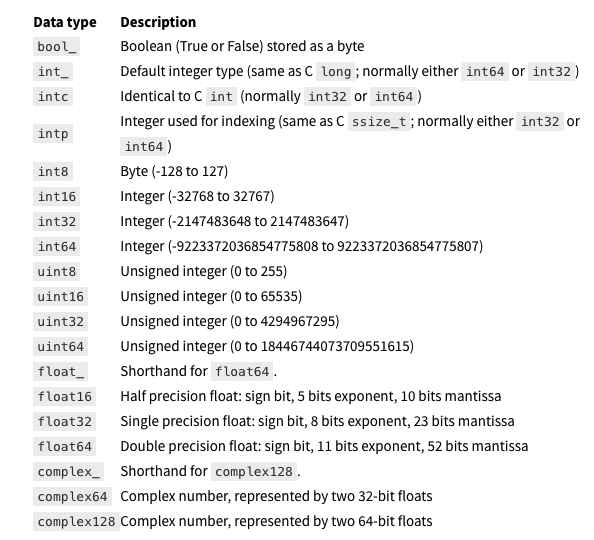

In [ ]:
# functions to change dtypes
def to_category(df, *args):
    for col_name in args:
        df[col_name] = df[col_name].astype("category")
    
def to_float32(df, *args):
    for col_name in args:
        df[col_name] = df[col_name].astype("float32")
        
def to_uint16(df, *args):
    for col_name in args:
        df[col_name] = df[col_name].astype("uint16")
  
def to_int32(df, *args):
    for col_name in args:
      df[col_name] = df[col_name].astype("int32")

def format_datetime(df, col_name):
    # get datetime obj for all timestamps
    dt = df[col_name].apply(datetime.datetime.fromtimestamp)
    
    df["time"] = dt.apply(lambda x: x.time())
    df["day_of_week"] = dt.apply(lambda x: x.weekday())
    df["month"] = dt.apply(lambda x: x.month)
    df["year"] = dt.apply(lambda x: x.year)

In [ ]:
# get a copy of the df
df_formatted = df.copy()

In [ ]:
# format all columns
format_datetime(df_formatted, "pingtimestamp")
to_category(df_formatted, ["trj_id", "driving_mode", "osname"])
to_float32(df_formatted, ["rawlat", "rawlng", "speed", "accuracy"])
to_uint16(df_formatted, ["bearing", "day_of_week", "month", "year"])
to_int32(df_formatted, "pingtimestamp")

In [ ]:
# check summary of df again
df_formatted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3034553 entries, 0 to 3034552
Data columns (total 13 columns):
 #   Column         Dtype   
---  ------         -----   
 0   trj_id         category
 1   driving_mode   category
 2   osname         category
 3   pingtimestamp  int32   
 4   rawlat         float32 
 5   rawlng         float32 
 6   speed          float32 
 7   bearing        uint16  
 8   accuracy       float32 
 9   time           object  
 10  day_of_week    uint16  
 11  month          uint16  
 12  year           uint16  
dtypes: category(3), float32(4), int32(1), object(1), uint16(4)
memory usage: 117.0+ MB


There's a significant reduction in memory usage.

---

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_formatted

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day_of_week,month,year
0,70014,car,android,1554943236,1.342326,103.888969,18.910000,248,3.9,00:40:36,3,4,2019
1,73573,car,android,1555582623,1.321781,103.856369,17.719076,44,4.0,10:17:03,3,4,2019
2,75567,car,android,1555141026,1.327088,103.861275,14.021548,34,3.9,07:37:06,5,4,2019
3,1410,car,android,1555731693,1.262482,103.823792,13.026521,181,4.0,03:41:33,5,4,2019
4,4354,car,android,1555584497,1.283799,103.807213,14.812943,93,3.9,10:48:17,3,4,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034548,67126,car,android,1554971237,1.349722,103.792839,18.255438,93,6.0,08:27:17,3,4,2019
3034549,11786,car,android,1555248352,1.386651,103.774857,23.341484,352,6.0,13:25:52,6,4,2019
3034550,21686,car,ios,1555805714,1.329604,103.822456,23.468313,111,5.0,00:15:14,6,4,2019
3034551,70139,car,android,1555685891,1.322202,103.887001,20.248346,266,6.0,14:58:11,4,4,2019


We can start by asking a few questions.



Why delay? What causes delay?
1. too few drivers/too much demand for transport services
2. traffic jam
3. bad ETA prediction 

How many trajectories (trips) do we have?

In [ ]:
df_formatted['trj_id'].nunique()

28000

In [ ]:
df_formatted['trj_id'].value_counts()

78371    674
77844    470
72549    435
79794    408
75826    373
        ... 
34226     52
60190     51
28734     50
61196     48
42338     48
Name: trj_id, Length: 28000, dtype: int64

Is there a huge difference between driving_mode?

Maybe motorcycles would have less delays than cars

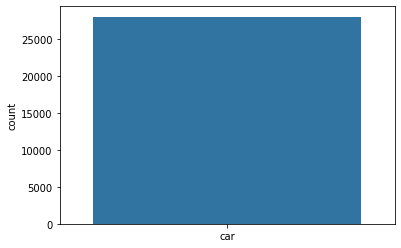

In [ ]:
driving_modes = df_formatted.groupby('trj_id').apply(lambda x: x.iloc[0, 1])
sns.countplot(x = driving_modes)

trj_id
10       car
100      car
1000     car
10001    car
10004    car
        ... 
997      car
9970     car
998      car
9982     car
9984     car
Length: 28000, dtype: object

Distribution of os

Different os might have different accuracy/bugs

In [ ]:
osnames = df_formatted.groupby('trj_id').apply(lambda x: x.iloc[0, 2])
sns.countplot(x = osnames)

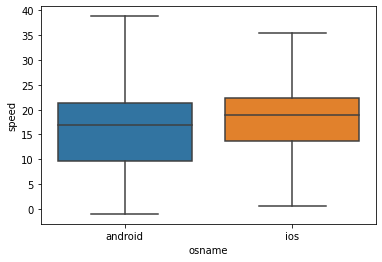

In [ ]:
sns.boxplot(data = df_formatted, x = 'osname', y = 'speed', showfliers = False)

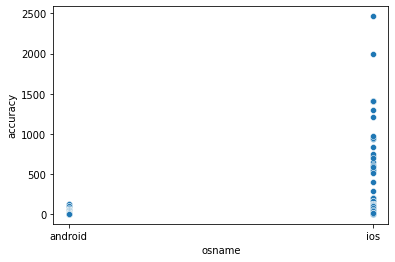

In [ ]:
plt.scatter(data = df_formatted, x = 'osname', y = 'accuracy')

ios results in higher inaccuracies of the tracking, resulting in higher delays.

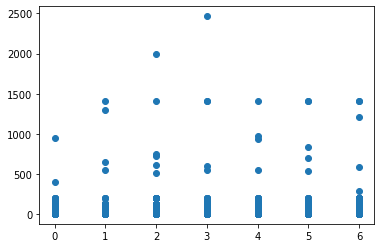

In [ ]:
plt.scatter( df_formatted['day_of_week'], df_formatted['accuracy'] )

sunday has lowest level of inaccuracies due to low level of traffic

Which period of time is the busiest?

7-10am? 5-7pm?

discretization

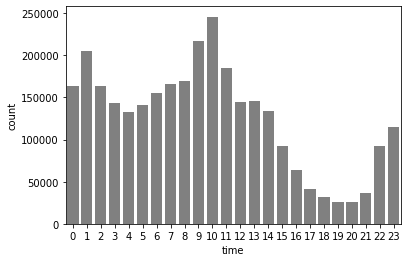

In [ ]:
hours = df_formatted['time'].apply(lambda x: x.hour)
sns.countplot(x = hours, color = 'grey')

0           0
1          10
2           7
3           3
4          10
           ..
3034548     8
3034549    13
3034550     0
3034551    14
3034552    23
Name: time, Length: 3034553, dtype: int64

In [ ]:
df_formatted['time']

0          00:40:36
1          10:17:03
2          07:37:06
3          03:41:33
4          10:48:17
             ...   
3034548    08:27:17
3034549    13:25:52
3034550    00:15:14
3034551    14:58:11
3034552    23:28:51
Name: time, Length: 3034553, dtype: object

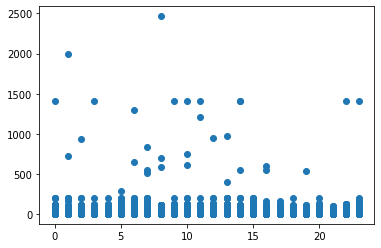

In [ ]:
plt.scatter(hours, df_formatted['accuracy'])

at noon time (7am - 3pm), there is higher inaccuracy observed 

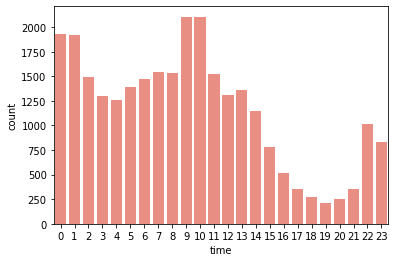

In [ ]:
initial_pings = df_formatted.groupby('trj_id')['time'].min()
initial_pings_hours = initial_pings.apply(lambda x: x.hour)
sns.countplot(x = initial_pings_hours, color = 'salmon')